# Let's understand the dataset

### Given files

- **train_data.zip** and **test_data.zip** - contains JSON files with multiple tables. The most important is ```sample_data.json```, which contains the primary identifiers used in the competition, as well as links to key image / lidar information.
    
- **train_images.zip** and **test_images.zip** - contains .jpeg files corresponding to samples in ```sample_data.json```
- **train_lidar.zip** and **test_lidar.zip** - contains .bin files corresponding to samples in ```sample_data.json```
- **train_maps.zip** and **test_maps.zip** - contains maps of the entire sample area.
- **train.csv** - contains all ```sample_tokens``` in the train set, as well as annotations in the required format for all train set objects.
- **sample_submission.csv** - contains all ```sample_tokens``` in the test set, with empty predictions.


In [1]:
!pip install -U git+https://github.com/lyft/nuscenes-devkit moviepy >> /dev/tmp

  Running command git clone -q https://github.com/lyft/nuscenes-devkit /tmp/pip-req-build-bd5iej2t


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

In [3]:
import pdb
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset, LyftDatasetExplorer, Quaternion, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

from moviepy.editor import ImageSequenceClip
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

## Introduction to the dataset structure

Let us go through a top-down introduction of the database. The dataset comprises of elemental building blocks that are the following:

1. `scene` - 25-45 seconds snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - (currently not used)
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

The data comes in the form of many interlocking tables and formats. The JSON files all contain single tables with identifying tokens that can be used to join with other files / tables. The images and lidar files all correspond to a sample in `sample_data.json`

We will be using [lyft's Dataset SDK](https://github.com/lyft/nuscenes-devkit/) for doing data analysis

In [5]:
# gotta do this for LyftDataset SDK, it expects folders to be named as `images`, `maps`, `lidar`

!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_data data

In [6]:
lyftdata = LyftDataset(data_path='.', json_path='data/', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 13.4 seconds.
Reverse indexing ...
Done reverse indexing in 5.3 seconds.


In [7]:
category_names = [i['name']for i in lyftdata.category]
converter = {}
for i, name in enumerate(category_names):
    converter[name] = i 
print(converter)

{'car': 0, 'pedestrian': 1, 'animal': 2, 'other_vehicle': 3, 'bus': 4, 'motorcycle': 5, 'truck': 6, 'emergency_vehicle': 7, 'bicycle': 8}


In [8]:
# Select points and lables for it
train_data_x, train_data_y = [], []
# test_x, test_y = [], [] 

for i in lyftdata.sample:
#     test_x.append(lyftdata.get('sample', i['token']))
    s = lyftdata.get('sample', i['token'])
    for a in s['anns']:
        my_annotation = lyftdata.get('sample_annotation', a)
        my_box = lyftdata.get_box(my_annotation['token'])
#         print(dir(my_box))
#         print(my_box)
#         print(my_box.wlh)
#         print(my_box.center)
#         print(my_box.orientation)
#         print(my_box.score)
        train_data_x.append(my_box.wlh)

#         print(my_annotation['category_name'])
#         print(str(my_annotation['category_name']))
#         print(converter[str(my_annotation['category_name'])])
        
        train_data_y.append(converter[str(my_annotation['category_name'])])
    
print(len(train_data_x))
print(len(train_data_y))
print(train_data_x[0])
print(train_data_y[0])
# lidar_top = lyftdata.get('sample_data', my_sample['data']['LIDAR_TOP']) # selecting LIDAR_TOP out of all LIDARs
# pc = LidarPointCloud.from_file(Path(lidar_top['filename'])) LOAD PC 
# print(lyftdata.sample))

638179
638179
[1.889 4.852 1.829]
0


In [10]:
# SPLIT AND CONVERT IN NUMPY ARRAY
# l = len(train_data_x) // 3
l = 10000
train_len = 0.9 * l

print(train_len)

train_x = []
train_y = []

test_x = []
test_y = []
# for i, data in enumerate(train_data_y):
#     if i > train_len:
# #         print('>', i)
#         test_y.append(data)
#         test_x.append(train_data_x[i])
#     else:
# #         print('<', i)
#         train_y.append(data)
#         train_x.append(train_data_x[i])

test_y = train_data_y[l:]
test_x = train_data_x[l:]

train_y = train_data_y[:l]
train_x = train_data_x[:l]

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

9000.0


In [11]:

print(train_x.shape)
print(train_x.min())
print(train_x.max())

print(train_y.shape)
print(train_y.min())
print(train_y.max())

print(test_x.shape)
print(test_x.min())
print(test_x.max())

print(test_y.shape)
print(test_y.min())
print(test_y.max())
print(test_x[0])
print(test_y[0])

(10000, 3)
0.223
22.802
(10000,)
0
8
(628179, 3)
0.223
22.802
(628179,)
0
8
[1.847 4.465 1.632]
0


# KNeighborsClassifier

In [13]:
# KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 90)
#knn.set_params(n_neighbors=10)
knn.fit(train_x, train_y)
y_test_predict = knn.predict(test_x)
err_test  = np.mean(test_y  != y_test_predict)
print(err_test)
err_test = 1 - knn.score(test_x, test_y) # Другой способ
print(err_test)
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_y, y_test_predict))
print(confusion_matrix([0,1,0,1,0], [0,1,0,0,0]))


0.04254997381319656
0.042549973813196584
[[522994      0      0   3496     24      0      0      0     18]
 [     0  24409      0      0      0      0      0      0     96]
 [     0     32      0      0      0      0      0      0    149]
 [  3052     72      0  29372    246      0      0      0    110]
 [    70      0      0   4335   4192      0      0      0      0]
 [     0      0      0      0      0      0      0      0    802]
 [  1297      0      0  10030   2630      0      0      0      0]
 [    68      0      0     62      0      0      0      0      0]
 [    73     67      0      0      0      0      0      0  20483]]
[[3 0]
 [1 1]]


In [14]:
# Долго!
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(train_x, train_y)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.019100000000000006 1


In [15]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(train_x, train_y)

err_train = np.mean(train_y != knn.predict(train_x))
err_test  = np.mean(test_y  != knn.predict(test_x))

print(err_train, err_test)

0.0 0.018179531630315562


# SVC

In [16]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(train_x, train_y)

err_train = np.mean(train_y != svc.predict(train_x))
err_test  = np.mean(test_y  != svc.predict(test_x))

print(err_train, err_test)

0.0322 0.035096684225356146


In [17]:
from sklearn.model_selection import GridSearchCV
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC(gamma='auto')
grid = GridSearchCV(svc, cv=3, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(train_x, train_y)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

0.02400000000000002 10.0


# Random Forest


In [19]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(train_x, train_y)

err_train = np.mean(train_y != rf.predict(train_x))
err_test  = np.mean(test_y  != rf.predict(test_x))

print(err_train, err_test)

0.0 0.015048258537773468


1.0
Feature ranking:
 1. feature '    l' (0.400018)
 2. feature '    w' (0.324618)
 3. feature '    h' (0.275364)


(-1, 3)

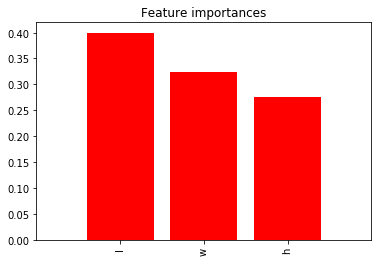

In [32]:
print(np.sum(rf.feature_importances_))

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

feature_names = ['w', 'l', 'h']

feature_imp = []

for f in range(len(feature_names)):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]])) # feature_names[indices[f]], importances[indices[f]]))
    feature_imp.append(feature_names[indices[f]])
# print(feature_names[[1, 0, 1]])


d_first = 3
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), feature_imp, rotation = 90)
plt.xlim([-1, d_first])

# Extremely Randomized Trees

In [29]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(train_x, train_y)

err_train = np.mean(train_y != ert.predict(train_x))
err_test  = np.mean(test_y  != ert.predict(test_x))

print(err_train, err_test)

0.0 0.014269817997736314


# AdaBoost

In [35]:
ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
ada.fit(train_x, train_y)

err_train = np.mean(train_y != ada.predict(train_x))
err_test = np.mean(test_y != ada.predict(test_x))

print(err_train, err_test)

0.1217 0.1258526630148413


# GBT

In [36]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 1000)
gbt.fit(train_x, train_y)

err_train = np.mean(train_y != gbt.predict(train_x))
err_test = np.mean(test_y != gbt.predict(test_x))

print(err_train, err_test)

0.0002 0.018639591581380465


# MLPClassifier 

In [37]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(train_x, train_y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [40]:
print("answ", mlp_model.predict([test_x[0, :]]))

y_train_pred = mlp_model.predict(train_x)
y_test_pred = mlp_model.predict(test_x)

print(np.mean(train_y != y_train_pred), np.mean(test_y != y_test_pred))
print(mlp_model.score(train_x, train_y), mlp_model.score(test_x, test_y))
print(1 - mlp_model.score(test_x, test_y))


answ [0]
0.0321 0.03616962681019264
0.9679 0.9638303731898074
0.036169626810192645


In [42]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(train_x, train_y)

    y_train_pred = mlp_model.predict(train_x)
    y_test_pred = mlp_model.predict(test_x)
    train_err.append(np.mean(train_y != y_train_pred))
    test_err.append(np.mean(test_y != y_test_pred))

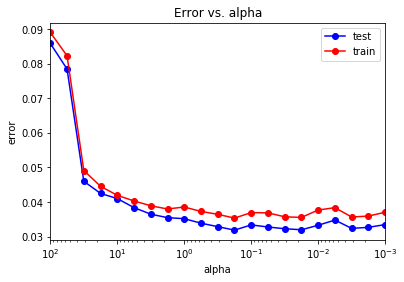

In [43]:

plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
    

In [44]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)
alpha_opt = alpha_opt[0]

0.0319 0.03536730772598256
[0.17782794]


In [47]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(train_x, train_y)

y_train_pred = mlp_model.predict(train_x)
y_test_pred = mlp_model.predict(test_x)
print(np.mean(train_y != y_train_pred))
print(np.mean(test_y != y_test_pred))

0.0319
0.03536730772598256


[[524162      0      0   2450    105     37   1509     68     20]
 [     0  24381     10     23      0      0      0      0     35]
 [     0     28    133      0      0      0      0      0      0]
 [  2331      0      0  29269   3303     32   7945     62      0]
 [    21      0      0    719   4509      0   1563      0      0]
 [     0      0      0     42      0     53      0      0     53]
 [     0      0      0    252    680      0   2940      0      0]
 [     0      0      0      0      0      0      0      0      0]
 [    18     96     38     97      0    680      0      0  20515]]


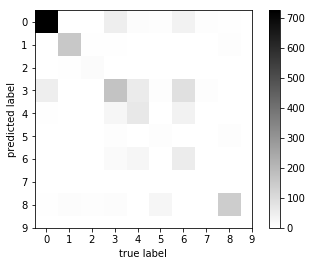

In [49]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, test_y))
M = confusion_matrix(y_test_pred, test_y)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

In [51]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    526532
           1       1.00      0.99      1.00     24505
           2       0.83      0.73      0.78       181
           3       0.68      0.89      0.77     32852
           4       0.66      0.52      0.59      8597
           5       0.36      0.07      0.11       802
           6       0.76      0.21      0.33     13957
           7       0.00      0.00      0.00       130
           8       0.96      0.99      0.98     20623

    accuracy                           0.96    628179
   macro avg       0.69      0.60      0.62    628179
weighted avg       0.96      0.96      0.96    628179



In [53]:
for i in range(l):
    Img = test_x[i, :]
    dig = test_y[i]
    dig_pred = mlp_model.predict([Img])[0]
    if dig_pred != dig:
        print(dig, dig_pred)
#         plt.subplot(8, 8, i_subplot)
#         draw_digit(Img, dig, dig_pred)
#         i_subplot += 1

NameError: name 'X_test' is not defined

The LyftDataset class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

The category table is simple: it holds the fields `name` and `description`. It also has a `token` field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:

In [ ]:
# print(lyftdata.list_categories())
print(lyftdata.table_names)
print(lyftdata.sample_annotation)
print(dir(lyftdata))

In [ ]:
cat_token = lyftdata.category[0]['token']
cat_token

If you know the `token` for any record in the DB you can retrieve the record by doing

In [ ]:
lyftdata.get('category', cat_token)

_As you can notice, we have recovered the same record!_

Ok. Let's try something harder. Let's look at the `sample_annotation` table.

In [ ]:
lyftdata.sample_annotation[0]

This also has a `token` field (they all do). In addition, it has several fields of the format [a-z]*\_token, _e.g._ instance_token. These are foreign keys in database terminology, meaning they point to another table. 
Using `lyftdata.get()` we can grab any of these in constant time. For example, let's look at the first attribute record.

In [ ]:
lyftdata.get('attribute', lyftdata.sample_annotation[0]['attribute_tokens'][0])

The attribute record indicates about what was the state of the concerned object when it was annotated.

Let's get started with the database schema, one by one starting with the `Scenes`

# Scenes

A scene is a 25-45s long sequence of consecutive frames extracted from a log. A frame (also called a `sample`) is a collection of sensor outputs (images, lidar points) at a given timestamp

```
scene {
   "token":                   <str> -- Unique record identifier.
   "name":                    <str> -- Short string identifier.
   "description":             <str> -- Longer description of the scene.
   "log_token":               <str> -- Foreign key. Points to log from where the data was extracted.
   "nbr_samples":             <int> -- Number of samples in this scene.
   "first_sample_token":      <str> -- Foreign key. Points to the first sample in scene.
   "last_sample_token":       <str> -- Foreign key. Points to the last sample in scene.
}
```

In [ ]:
lyftdata.scene[0]

Each scene provides the first sample token and the last sample token, we can see there are 126 sample records (`nbr_samples`) in between these two.

### Let's take a look at train.csv

In [ ]:
train = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/train.csv')
train.head()

train dataframe's `Id` column contains tokens (unique identifiers) of train sample records present in `sample` table and `PredictionString` contains corresponding ground truth annotations (bounding boxes) for different object categories

In [ ]:
token0 = train.iloc[0] # .keys()
token0

We'll be using `token0` to as our reference sample token

# Sample

A `sample` is defined as an annotated keyframe of a `scene` at a given timestamp. A sample is data collected at (approximately) the same timestamp as part of a single LIDAR sweep. 

```
sample {
   "token":                   <str> -- Unique record identifier.
   "timestamp":               <int> -- Unix time stamp.
   "scene_token":             <str> -- Foreign key pointing to the scene.
   "next":                    <str> -- Foreign key. Sample that follows this in time. Empty if end of scene.
   "prev":                    <str> -- Foreign key. Sample that precedes this in time. Empty if start of scene.
}
```

Remember, `token0` is a token to a particular sample record in `sample` data table (`sample.json`), let's look at that sample using lyft SDK's inbuilt `.get` function

In [ ]:
my_sample = lyftdata.get('sample', token0)
my_sample

# 3D interactive visualization of a sample

We can visualize a sample interactively using lyft SDK's inbuilt `render_sample_3d_interactive` functionality

In [ ]:
lyftdata.render_sample_3d_interactive(my_sample['token'], render_sample=False)

Let's see what else have we got ..

In [ ]:
my_sample.keys()

So our `token0` points to `my_sample` record in `sample` data table. This sample record has got 7 camera images and 3 LIDAR data files, which can be fetched using their respective tokens, from where? none other than `sample_data` table.

# Sample data

`sample_data` is a sensor data e.g. image or point cloud.

```
sample_data {
   "token":                   <str> -- Unique record identifier.
   "sample_token":            <str> -- Foreign key. Sample to which this sample_data is associated.
   "ego_pose_token":          <str> -- Foreign key.
   "calibrated_sensor_token": <str> -- Foreign key.
   "filename":                <str> -- Relative path to data-blob on disk.
   "fileformat":              <str> -- Data file format.
   "width":                   <int> -- If the sample data is an image, this is the image width in pixels.
   "height":                  <int> -- If the sample data is an image, this is the image height in pixels.
   "timestamp":               <int> -- Unix time stamp.
   "is_key_frame":            <bool> -- True if sample_data is part of key_frame, else False.
   "next":                    <str> -- Foreign key. Sample data from the same sensor that follows this in time. Empty if end of scene.
   "prev":                    <str> -- Foreign key. Sample data from the same sensor that precedes this in time. Empty if start of scene.
}
```

The dataset contains data that is collected from a full sensor suite. Hence, for each snapshot of a scene, we are provided with references to a family of data that is collected from these sensors. 

The full sensor suite consists of:
* 7 cameras,
* 3 LIDARs

In [ ]:
lyftdata.sensor

We can use `data` key of a given sample to access one of these, like:

In [ ]:
sensor = 'CAM_FRONT'
cam_front = lyftdata.get('sample_data', my_sample['data'][sensor])
cam_front

Every `sample_data` has a record of the `sensor` from which the data was collected from (note the "channel" key). Let's see image taken by front camera (CAM_FRONT)

In [ ]:
img = Image.open(cam_front['filename'])
img

We can also use SDK's inbuilt `render_sample_data` to visualize `cam_front` data (remember `cam_front` is a record in `sample_data` table)

In [ ]:
lyftdata.render_sample_data(cam_front['token'], with_anns=False)

let's take a look at the LIDAR data associated with `my_sample`

In [ ]:
lidar_top = lyftdata.get('sample_data', my_sample['data']['LIDAR_TOP']) # selecting LIDAR_TOP out of all LIDARs
lidar_top

We can use `LidarPointCloud` to read LIDAR data files

In [ ]:
pc = LidarPointCloud.from_file(Path(lidar_top['filename']))

In [ ]:
pc.points.shape # x, y, z, intensity
pc.points

Let's visualize these lidar points

In [ ]:
axes_limits = [
    [-30, 50], # X axis range
    [-30, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def display_frame_statistics(lidar_points, points=0.2):
    """
    Displays statistics for a single frame. Draws 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    lidar_points: lidar data points 
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    pc_frame = lidar_points[:, pc_range]
    def draw_point_cloud(ax, title, axes=[0, 1, 2]):
        """Convenient method for drawing various point cloud projections as a part of frame statistics"""
        ax.set_facecolor('black')
        ax.grid(False)
        ax.scatter(*pc_frame[axes, :], s=point_size, c='white', cmap='grey')
        if len(axes) == 3: # 3D configs
            text_color = 'white'
            ax.set_xlim3d([-10, 30])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]), color='white')
        else: # 2D configs
            text_color = 'black' # the `figure` is white
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        ax.set_title(title, color=text_color)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]), color=text_color)
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]), color=text_color)
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')
    # make the panes transparent
    ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    draw_point_cloud(ax2, '3D plot')
    
    plt.show()
    plt.close(f2)
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
#     f.set_facecolor('black')
    draw_point_cloud(
        ax3[0], 
        'XZ projection (Y = 0)', #, the car is moving in direction left to right', ?
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'XY projection (Z = 0)', #, the car is moving in direction left to right',? 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'YZ projection (X = 0)', #, the car is moving towards the graph plane', ?
        axes=[1, 2] # Y and Z axes
    )
    plt.show()
    plt.close(f)

In [ ]:
display_frame_statistics(pc.points, points=0.5)

We can also use SDK's inbuilt `render_sample_data` to visualize `lidar_top` (remember `lidar_top` is a record in `sample_data` table, just like `cam_front` is )

In [ ]:
lyftdata.render_sample_data(lidar_top['token'], with_anns=False)

So, above plots show a particular LIDAR sensor (`TOP_LIDAR`), Each sensor is mounted on a ego vehicle aka Autonomous vehicle (AV), here comes `ego_pose`

## ego_pose

`ego_pose` contains information about the location (encoded in `translation`) and the orientation (encoded in `rotation`) of the ego vehicle body frame, with respect to the global coordinate system.

In [ ]:
lyftdata.get('ego_pose', cam_front['ego_pose_token'])

ego_pose parameters are used to bring points from global coordinates system (say bounding boxes' corners) to ego vehicle's frame of reference. As we know that each ego vehicle has a bunch of sensors, each sensor has got some calibration parameters w.r.t ego vehicle

## caliberated_sensor

`calibrated_sensor` consists of the definition of a particular sensor (lidar/radar/camera) as calibrated on a particular vehicle. Let us look at an example.

In [ ]:
lyftdata.get('calibrated_sensor', cam_front['calibrated_sensor_token'])

All extrinsic parameters are given with respect to the ego vehicle body frame. We use caliberate_sensor's parameters to bring points from ego vehicle's frame of reference to sensor's frame of reference. It is used to plot bounding boxes in the images and lidar point cloud.

We'll need sensor calibration and ego_pose parameters when plotting bounding boxes together with the lidar point cloud. We'll see this later on, before that let's visualize other stuff which `my_sample` has got, starting with bounding box annotations

# Annotations

`sample_annotation` refers to a bounding box defining the position of an object seen in a sample.
All location data is given with respect to the global coordinate system.
```
sample_annotation {
   "token":                   <str> -- Unique record identifier.
   "sample_token":            <str> -- Foreign key. NOTE: this points to a sample NOT a sample_data since annotations are done on the sample level taking all relevant sample_data into account.
   "instance_token":          <str> -- Foreign key. Which object instance is this annotating. An instance can have multiple annotations over time.
   "attribute_tokens":        <str> [n] -- Foreign keys. List of attributes for this annotation. Attributes can change over time, so they belong here, not in the object table.
   "visibility_token":        <str> -- Foreign key. Visibility may also change over time. If no visibility is annotated, the token is an empty string.
   "translation":             <float> [3] -- Bounding box location in meters as center_x, center_y, center_z.
   "size":                    <float> [3] -- Bounding box size in meters as width, length, height.
   "rotation":                <float> [4] -- Bounding box orientation as quaternion: w, x, y, z.
   "num_lidar_pts":           <int> -- Number of lidar points in this box. Points are counted during the lidar sweep identified with this sample.
   "num_radar_pts":           <int> -- Number of radar points in this box. Points are counted during the radar sweep identified with this sample. This number is summed across all radar sensors without any invalid point filtering.
   "next":                    <str> -- Foreign key. Sample annotation from the same object instance that follows this in time. Empty if this is the last annotation for this object.
   "prev":                    <str> -- Foreign key. Sample annotation from the same object instance that precedes this in time. Empty if this is the first annotation for this object.
}
```

In [ ]:
my_annotation = lyftdata.get('sample_annotation', my_sample['anns'][0])
my_annotation
# my_box = lyftdata.get_box(my_annotation['token'])
# my_box # Box class instance

In [ ]:
len(my_sample.keys())
my_sample.keys()

Each annotation has all location data with respect to global coordinate system. We will have to take care of rotation, translation and size into account before finalizing the final bounding box coordinates on the sample images luckily we have an inbuilt function for that

In [ ]:
my_box = lyftdata.get_box(my_annotation['token'])
my_box # Box class instance

In [ ]:
my_box.center, my_box.wlh # center coordinates + width, length and height

Let's see our `my_annotation` (remember it is a single object annotation out of the many present in `my_sample`) using the SDK's inbuilt `render_annotation` function

In [ ]:
lyftdata.render_annotation(my_annotation['token'], margin=10)

Each annotation has an `attribute`:

# Attributes

An attribute is a property of an instance that can change while the category remains the same.
 Example: a vehicle being parked/stopped/moving, and whether or not a bicycle has a rider.
```
attribute {
   "token":                   <str> -- Unique record identifier.
   "name":                    <str> -- Attribute name.
   "description":             <str> -- Attribute description.
}
```

In [ ]:
my_attribute1 = lyftdata.get('attribute', my_annotation['attribute_tokens'][0])
my_attribute2 = lyftdata.get('attribute', my_annotation['attribute_tokens'][1])

In [ ]:
my_attribute1

In [ ]:
my_attribute2

Looks like our subject is standstill

# Instances

Object instance are instances that need to be detected or tracked by an autonomous vehicle (e.g a particular vehicle, pedestrian). Let us examine an instance metadata

In [ ]:
my_instance = lyftdata.get('instance', my_annotation['instance_token'])
my_instance

In [ ]:
lyftdata.render_instance(my_instance['token'])

In [ ]:
dir(lyftdata)

People generally track an instance across different frames in a particular scene. That's why we have `first_annotation_token` and `last_annotation_token` in `my_instance`

In [ ]:
print("First annotated sample of this instance:")
lyftdata.render_annotation(my_instance['first_annotation_token'])

In [ ]:
print("Last annotated sample of this instance")
lyftdata.render_annotation(my_instance['last_annotation_token'])

So far we have seen that each sample data point has a bunch of images taken from different cameras, a bunch of lidar data points taken from different lidar sensors, it has annotations for the objects in those images, attributes associated with those annotations. Let's visualize everything which this data point has got in itself using SDK's inbuit `render_sample` function

In [ ]:
lyftdata.render_sample(token0)

# 3D visualization of a scene

In [ ]:
my_scene = lyftdata.get('scene',  my_sample['scene_token'])

Let's visualize `LIDAR_TOP` of all the samples of our `my_scene` in 3D. Here's how we are gonna do this:
* Each lidar point cloud is in [lidar ranger](https://en.wikipedia.org/wiki/Laser_rangefinder)'s frame of reference, we have to get each point in vehicle's frame of reference. 
* Each bounding box corners are in global coordinate system, we get them to ego vehicles frame of reference using ego_pose parameters. 
* Once we have the lidar point and box corners in vehicle's frame of reference, we plot the points using matplotlib's scatter function and draw the box edges using matplotlib's plot function

In [ ]:
def get_lidar_points(lidar_token):
    '''Get lidar point cloud in the frame of the ego vehicle'''
    sd_record = lyftdata.get("sample_data", lidar_token)
    sensor_modality = sd_record["sensor_modality"]
    
    # Get aggregated point cloud in lidar frame.
    sample_rec = lyftdata.get("sample", sd_record["sample_token"])
    chan = sd_record["channel"]
    ref_chan = "LIDAR_TOP"
    pc, times = LidarPointCloud.from_file_multisweep(
        lyftdata, sample_rec, chan, ref_chan, num_sweeps=1
    )
    # Compute transformation matrices for lidar point cloud
    cs_record = lyftdata.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
    pose_record = lyftdata.get("ego_pose", sd_record["ego_pose_token"])
    vehicle_from_sensor = np.eye(4)
    vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
    vehicle_from_sensor[:3, 3] = cs_record["translation"]
    
    ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
    rot_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
    )
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle
    points = view_points(
        pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
    )
    return points

In [ ]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=1.0):
    '''Plot boxes in the 3d figure'''
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

In [ ]:
def draw_3d_plot(idx, lidar_token):
    '''Plot the lidar + annotations on a 3D figure'''
    # sample lidar point cloud
    lidar_points = get_lidar_points(lidar_token)
    points = 0.5 # fraction of lidar_points to plot, to reduce the clutter
    points_step = int(1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    lidar_points = lidar_points[:, pc_range]
    
    # Get boxes, instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
    _, boxes, _ = lyftdata.get_sample_data(
        lidar_token, flat_vehicle_coordinates=True
    )
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')                    
    point_size = 0.01 * (1. / points) # size of the dots on plot
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(*lidar_points, s=point_size, c='white', cmap='gray')
    for box in boxes:
        c = np.array(lyftdata.explorer.get_color(box.name)) / 255.0
        plot_box(box, ax, view=np.eye(3), colors=(c, c, c), linewidth=0.5)
    ax.set_xlim3d(-40, 40)
    ax.set_ylim3d(-40, 40)
    ax.set_zlim3d(-4, 40)
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title(lidar_token, color='white')
    filename = 'tmp/frame_{0:0>4}.png'.format(idx)
    plt.savefig(filename)
    plt.close(fig)
    return filename

In [ ]:
!mkdir tmp # a temporary folder to contain plot jpegs

In [ ]:
# let's take a quick look at the 3d Plot
first_sample_token = my_scene['first_sample_token']
sample = lyftdata.get('sample', first_sample_token)
lidar_token = sample['data']['LIDAR_TOP']
filename = draw_3d_plot(0, lidar_token)
Image.open(filename)

Let's visualize `my_scene` in the form of a video

In [ ]:
frames = []
first_sample_token = my_scene['first_sample_token']
token = first_sample_token
for i in tqdm(range(my_scene['nbr_samples'])):
    sample = lyftdata.get('sample', token)
    lidar_token = sample['data']['LIDAR_TOP']
    filename = draw_3d_plot(i, lidar_token)
    frames += [filename]
    token = sample['next']
#     break

In [ ]:
clip = ImageSequenceClip(frames, fps=5)
clip.write_gif('pcl_data.gif', fps=5);

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

In [ ]:
with open('pcl_data.gif','rb') as f:
    display.Image(data=f.read(), format='png')

In [ ]:
!rm -r tmp/*

We can also use lyft SDK's `render_scene` function to render a scene like this:

In [ ]:
# The rendering command below is commented out because it tends to crash in notebooks,
# lyftdata.render_scene(my_scene['token'])

 I've uploaded it on YouTube
 



In [ ]:
HTML('<iframe width="700" height="500" src="https://www.youtube.com/embed/Vs8H8Fs-zTs" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# 3D visualization tool: `nuscenes_viz`

I've built this awesome tool to interactively visualize lidar point cloud and corresponding bounding boxes in 3D using [mayavi](https://github.com/enthought/mayavi). It's called `nuscenes_viz`

Checkout the source code: [here](https://github.com/pyaf/nuscenes_viz)

Here's a demo video:

In [ ]:
HTML('<iframe width="700" height="430" src="https://www.youtube.com/embed/ivmiN4zvRTo" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Do upvote if you liked this kernel :)

## References

* https://github.com/lyft/nuscenes-devkit/
* https://github.com/nutonomy/nuscenes-devkit/blob/master/schema.md
* https://github.com/enginBozkurt/Visualizing-lidar-data/